## This notebook brings you through the syllabification process one step at a time, to refine/visualize the algorithm
- This notebook takes WAV datasets generated by `1.0-segment-song-from-wavs` and segments the WAVs into spectrograms of syllables 
  - WAVs are expected to be in this format: `2017-04-16_17-27-44-760000.wav`
- The notebook outputs and HDF5 file which contains metadata about who the individual is, when the syllable was sung, how long the syllable is, which file the syllable comes from

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from datetime import datetime
import pandas as pd
import copy

In [40]:
from avgn.utils.audio import load_wav, int16_to_float32
from avgn.utils.paths import DATA_DIR, ensure_dir
from avgn.utils.general import save_dict_pickle, zero_one_norm, rescale
from avgn.signalprocessing.spectrogramming import _build_mel_basis, inv_spectrogram
from avgn.bout_to_syllables import dynamic_spectrogram, contiguous_regions, resize_compressed_syllable, cut_syllables, resize_syllables, thresh_mode, pad_spectrogram
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.visualization.spectrogram import plot_syllable_list, plot_segmentations, plot_bout_to_syllable_pipeline

### Parameters for segmenting syllables

In [4]:
# the size of the syllables (pixels*pixels)
syll_size = 128

# parameters for filtering
filtering_params = {
    # filtering
    "highcut": 15000,
    "lowcut": 500,
}

spectrogramming_params = {
    # spectrograms
    "mel_filter": True,  # should a mel filter be used?
    "num_mels": syll_size,  # how many channels to use in the mel-spectrogram
    "num_freq": 512,  # how many channels to use in a spectrogram
    "num_freq_final": syll_size,  # how many channels to use in the resized spectrogram
    "sample_rate": 44100,  # what rate are your WAVs sampled at?
    "preemphasis": 0.97,
    "min_silence_for_spec": 0.5,  # minimum length of silence for a spectrogram to be considered a good spectrogram
    "max_vocal_for_spec": 5.0,  # the longest a single vocalization (protosyllable) is allowed to be
    "frame_shift_ms": 0.5,  # step size for fft
    "frame_length_ms": 6,  # frame length for fft
    "min_level_dB": -80,  # minimum threshold db for computing spe
    "min_level_dB_floor": -20,  # (db)
    "spec_thresh_delta_dB": 5,  # (db) what
    "ref_level_dB": 20,  # reference db for computing spec
    "sample_rate": 44100,  # sample rate of your data
    "fmin_mel": 300,  # low frequency cutoff for mel filter
    "fmax_mel": None,  # high frequency cutoff for mel filter
}

envelope_params = {
    # Vocal Envelope
    "smoothing": "gaussian",  # 'none',
    "envelope_signal": "spectrogram",  # spectrogram or waveform, what to get the vocal envelope from
    "gauss_sigma_s": 0.0001,
    "FOI_min": 4,  # minimum frequency of interest for vocal envelope (in terms of mel)
    "FOI_max": 24,  # maximum frequency of interest for vocal envelope (in terms of mel)
}

bout_threshold_params = {
    # Silence Thresholding
    "silence_threshold": 0.001,  # normalized threshold for silence
    "min_len": 5.0,  # minimum length for a vocalization (fft frames)
    "power_thresh": 0.3,  # Threshold for which a syllable is considered to be quiet weak and is probably noise
}

syllabification_params = {
    # Syllabification
    "min_syll_len_s": 0.03,  # minimum length for a syllable
    "segmentation_rate": 0.0,  # 0.125, # rate at which to dynamically raise the segmentation threshold (ensure short syllables)
    "threshold_max": 0.25,
    "min_num_sylls": 20,  # min number of syllables to be considered a bout
    "slow_threshold": 0.0,  # 0.02, # second slower threshold
    "max_size_syll": syll_size,  # the size of the syllable
    "resize_samp_fr": int(
        syll_size * 5.0
    ),  # (frames/s) the framerate of the syllable (in compressed spectrogram time components)
    # Sencond pass syllabification
    "second_pass_threshold_repeats": 50,  # the number of times to repeat the second pass threshold
    "ebr_min": 0.05,  # expected syllabic rate (/s) low
    "ebr_max": 0.2,  # expected syllabic rate (/s) high
    "max_thresh": 0.02,  # maximum pct of syllabic envelope to threshold at in second pass
    "thresh_delta": 0.005,  # delta change in threshold to match second pass syllabification
    "slow_threshold": 0.005,  # starting threshold for second pass syllabification
}

spectrogram_inversion_params = {
    # spectrogram inversion
    "max_iters": 200,
    "griffin_lim_iters": 60,
    "power": 1.5,
    # Thresholding out noise
    "mel_noise_filt": 0.15,  # thresholds out low power noise in the spectrum - higher numbers will diminish inversion quality
}

hparams = {}

for d in [
    filtering_params,
    spectrogramming_params,
    envelope_params,
    bout_threshold_params,
    syllabification_params,
    spectrogram_inversion_params,
]:
    for k, v in d.items():
        hparams[k] = v

In [5]:
# this is used to identify this training instance
now_string = datetime.now().strftime(
    "%Y-%m-%d_%H-%M-%S"
)  
# save the dictionary so that we can reload it for recovering waveforms
dict_save = DATA_DIR / ("parameter_dictionaries/" + now_string + "_dict.pickle")
ensure_dir(dict_save)
save_dict_pickle(hparams, dict_save)
print(dict_save)

/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/data/parameter_dictionaries/2019-04-25_13-59-42_dict.pickle


### read WAV data

In [6]:
wav_loc = '../../../data/bf_wav/Bird0/wavs/1900-03-03_00-00-00-000000.wav'

In [7]:
# read in the data
csv_loc = "/".join(
    wav_loc.split("/")[:-2] + ["csv"] + [wav_loc.split("/")[-1][:-4] + ".csv"]
)
rate, data = load_wav(wav_loc)

In [8]:
hparams["sample_rate"] = rate

In [9]:
(bird, original_wav, start_time) = pd.read_csv(csv_loc, header=None).values[0]
start_time = datetime.strptime(start_time, "%Y-%m-%d_%H-%M-%S-%f")

In [10]:
# bandpass filter data
data = butter_bandpass_filter(data, hparams['lowcut'], hparams['highcut'], rate, order=2).astype('float32')

In [11]:
print('Rate: ', rate, 'Time sung: ',start_time, 'Length:', len(data)/float(rate))

Rate:  32000 Time sung:  1900-03-03 00:00:00 Length: 11.609


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

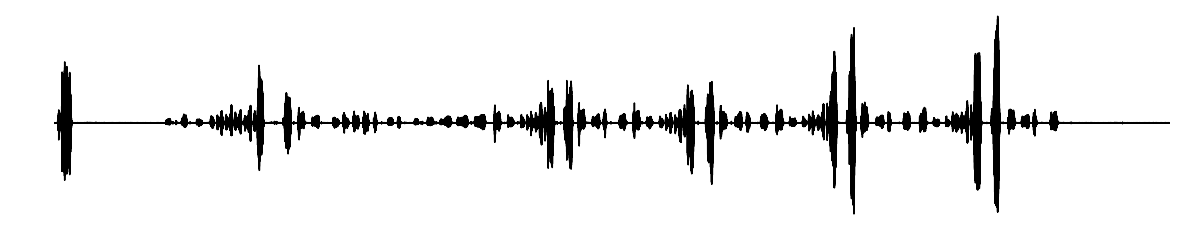

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(data, color='black')
ax.set_xlim((0, len(data)))
ax.axis('off')
plt.show()

In [14]:
# play back a sample of the song
IPython.display.Audio(data=data[:rate*10], rate=44100)

### Build a Mel basis function

In [15]:
# build a basis function if you are using a mel spectrogram
_mel_basis = _build_mel_basis(hparams) 

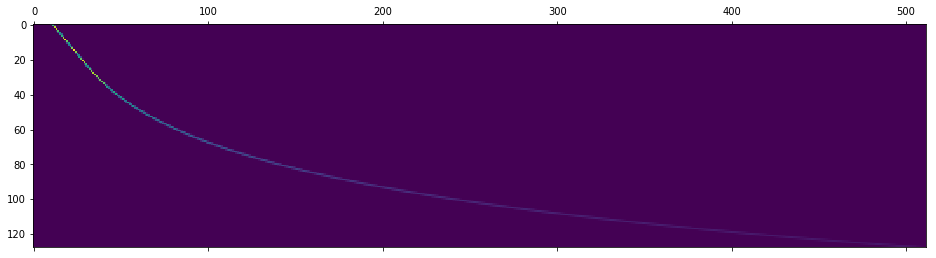

In [16]:
# this is what the mel filter looks like
plt.matshow(_mel_basis)

### Compute the spectrogram

In [17]:
# Generates the spectrogram and also thresholds out bad spectrograms (e.g. too noisy) - take a look at wav_to_syllables.py to determine if you want this
spec, vocal_envelope, cur_spec_thresh, fft_rate = dynamic_spectrogram(data/np.max(np.abs(data)), _mel_basis = _mel_basis, hparams=hparams, verbose=True)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


longest silence 0.9705
longest vocalization 0.155


<Figure size 432x288 with 0 Axes>

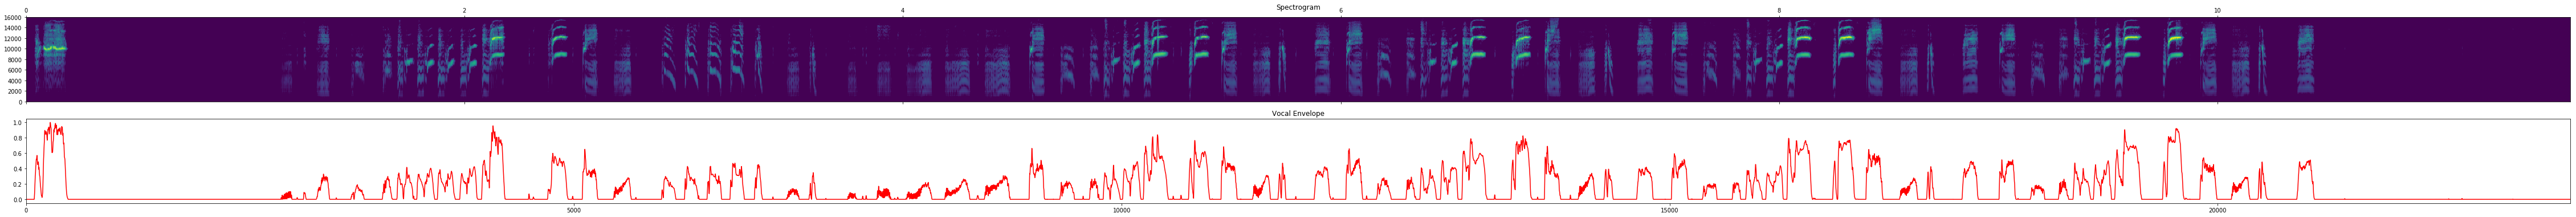

In [18]:
# visualize the generated spectrogram
plt.clf()
start_time = 0
stop_time = np.shape(spec)[1] / fft_rate
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(80, 6))

ax[0].matshow(
    spec,
    interpolation=None,
    aspect="auto",  # cmap=plt.cm.gray_r,
    cmap=plt.cm.viridis,
    origin="lower",
    extent=[start_time, stop_time, 0, rate / 2],
)
ax[0].set_title("Spectrogram")

ax[1].plot(vocal_envelope, color="red")
ax[1].set_xlim([0, len(vocal_envelope)])
ax[1].set_title("Vocal Envelope")
plt.show()

### Output some stats of our file

In [19]:
print("".join(["new Spectrogram Size: ", str(np.shape(spec))]))
print("".join(["Original Waveform Size: ", str(np.shape(data))]))
print("".join(["Length (s): ", str(len(data) / float(rate))]))
print("".join(["Original Sampling Rate (ms) : ", str(1.0 / float(rate))]))
print(
    "".join(
        [
            "New Sampling Rate (ms): ",
            str(round((len(data) / float(rate)) * 1000 / float(np.shape(spec)[1]), 3)),
        ]
    )
)

new Spectrogram Size: (128, 23219)
Original Waveform Size: (371488,)
Length (s): 11.609
Original Sampling Rate (ms) : 3.125e-05
New Sampling Rate (ms): 0.5


### Detect onsets and offsets of noise/vocalization

In [20]:
# Detect onsets and offsets of vocal envelope
onsets, offsets = np.array(
    contiguous_regions(vocal_envelope > hparams["silence_threshold"])
).T
print(onsets[0:10], offsets[0:10], len(onsets))

[  75 2326 2335 2344 2467 2533 2649 2829 2965 2996] [ 385 2333 2343 2427 2480 2557 2773 2836 2993 3089] 124


### Segment into syllables

In [21]:
# segment into syllables based upon onset/offsets
all_syllables, all_syllable_starts, all_syllable_lens = cut_syllables(
    onsets, offsets, spec, fft_rate, hparams
)
# Timing for when each syllable started (seconds)
print(all_syllable_starts[0:5])

[0.0375, 1.163, 1.1675, 1.172, 1.2335]


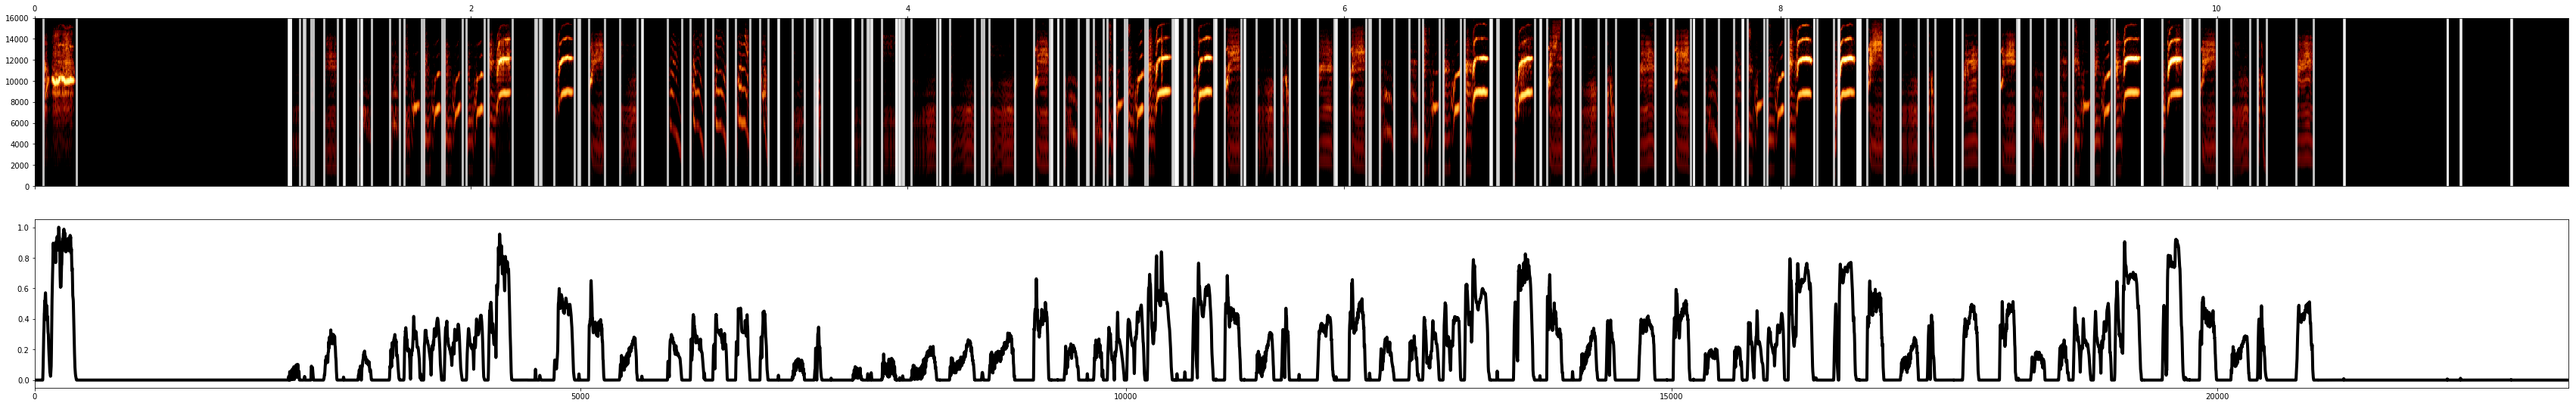

In [24]:
plot_segmentations(
    spec, vocal_envelope, all_syllable_starts, all_syllable_lens, fft_rate, hparams
)

### Threshold syllable lengths

In [25]:
print(len(all_syllable_lens))

124


0.0005 0.155 0.04423387096774194
[0.155, 0.0035, 0.004, 0.0415, 0.0065]


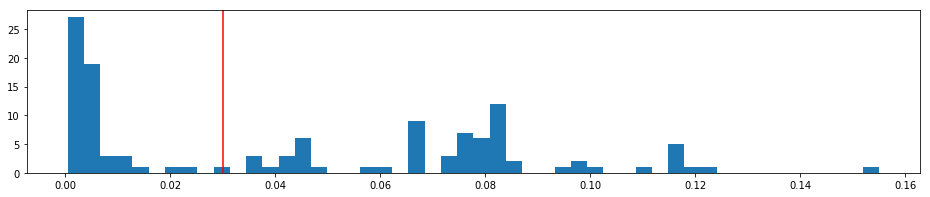

In [26]:
# Plot how we've thresholded out syllables which are too short to be considered song
print(np.min(all_syllable_lens), np.max(all_syllable_lens), np.mean(all_syllable_lens))
print(all_syllable_lens[0:5])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
_ = plt.hist(all_syllable_lens, bins=50)
ax.axvline(x=hparams["min_syll_len_s"], color="red")
plt.show()

In [27]:
syll_len_mask = np.array(all_syllable_lens) >= hparams["min_syll_len_s"]
all_syllables = [syll for syll, mask in zip(all_syllables, syll_len_mask) if mask]
all_syllable_starts = np.array(all_syllable_starts)[syll_len_mask]
all_syllable_lens = np.array(all_syllable_lens)[syll_len_mask]

In [28]:
all_syllables_full_len = copy.deepcopy(all_syllables)

### Resize and Pad Spectrograms

In [29]:
# resize syllables
all_syllables_resized = resize_syllables(all_syllables, fft_rate, hparams)

In [30]:
# set mode to 0
all_syllables_resized = [thresh_mode(syll) for syll in all_syllables_resized]

In [31]:
# 0 pad syllables
all_syllables_comp = np.array(
    [pad_spectrogram(i, hparams["max_size_syll"]) for i in all_syllables_resized]
)

In [32]:
# convert to 8 bit
all_syllables_comp = [(zero_one_norm(i)*255).astype('uint8') for i in all_syllables_comp]

### Plot final output

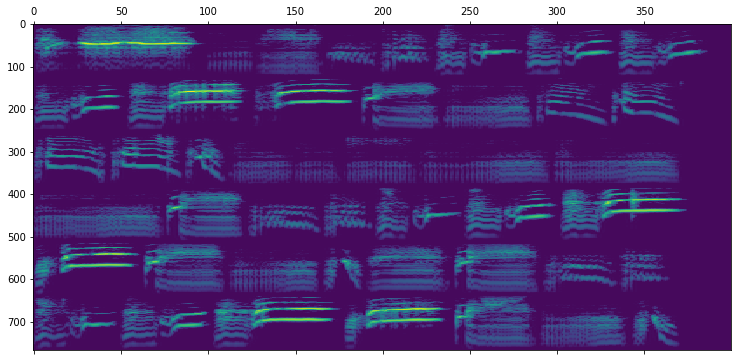

In [33]:
plot_syllable_list(all_syllables, hparams["num_freq_final"], max_rows=6)

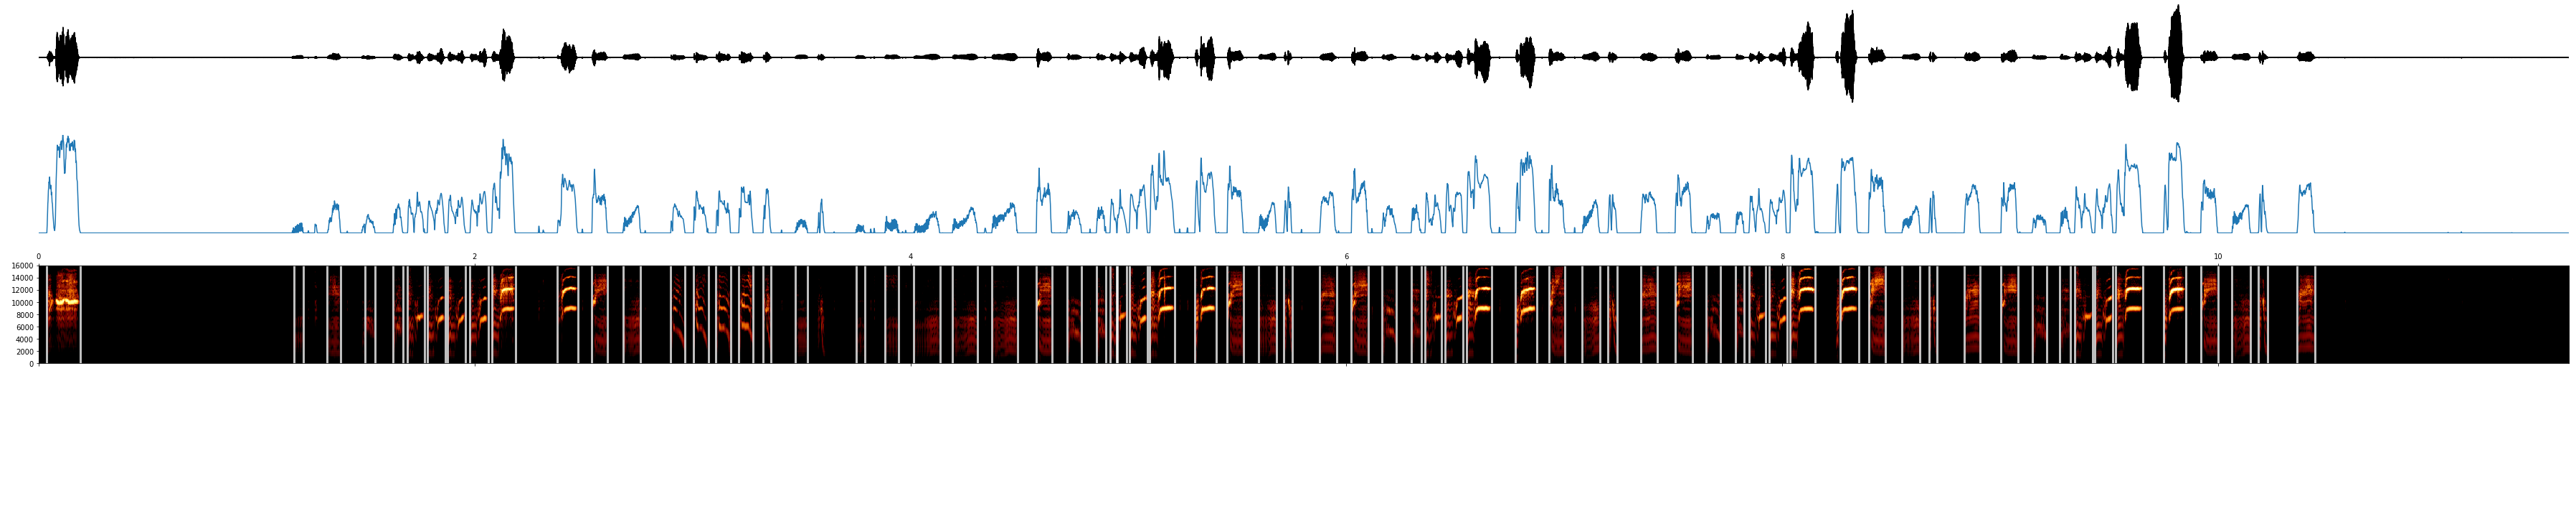

In [34]:
plot_bout_to_syllable_pipeline(data, vocal_envelope, spec, onsets, offsets, all_syllables, all_syllable_starts, all_syllable_lens, rate, fft_rate)

## Test spectral reconstruction on syllable

#### Reconstruction on syllables that have not been compressed in time

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


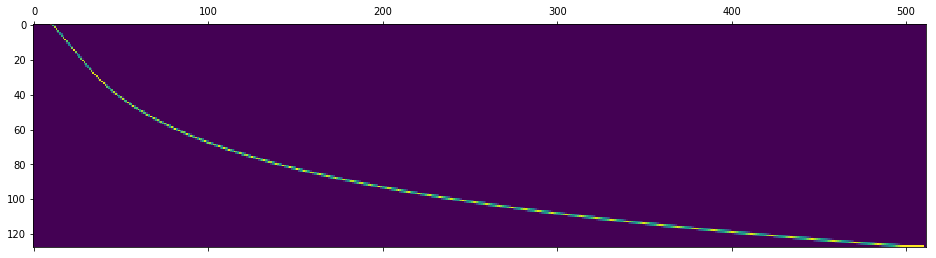

In [35]:
# create the mel inversion filter
mel_inversion_filter = (_mel_basis.T / _mel_basis.sum(axis=1))
mel_inversion_filter =np.nan_to_num(np.transpose(mel_inversion_filter / mel_inversion_filter.sum(axis=1)[:, np.newaxis]))
plt.matshow(mel_inversion_filter)

#### Test spectral reconstruction on syllable

In [41]:
noise = 0.001
syll_num = 10
# get syllable
syll = all_syllables_comp[syll_num]
# reshape/convolve with filter
syll_resized = resize_compressed_syllable(syll, hparams, mel_inversion_filter)
### adding some noise tends to improve reconstruction quality
syll_scaled = rescale(syll_resized, 0, 1) + np.reshape(
    np.random.rand(np.prod(np.shape(syll_resized))) * noise, np.shape(syll_resized)
)
# test spectrogram inversion
waveform_reconstructed = inv_spectrogram(syll_scaled, hparams)
# grab the original waveform
waveform_original = data[
    int(all_syllable_starts[syll_num] * rate) : int(
    (all_syllable_starts[syll_num] + all_syllable_lens[syll_num]) * rate
    )
]
# join the two
joined_wavs = np.concatenate([(waveform_original/np.max(waveform_original)), np.zeros(int(rate*.05)), (waveform_reconstructed/waveform_reconstructed.max())])

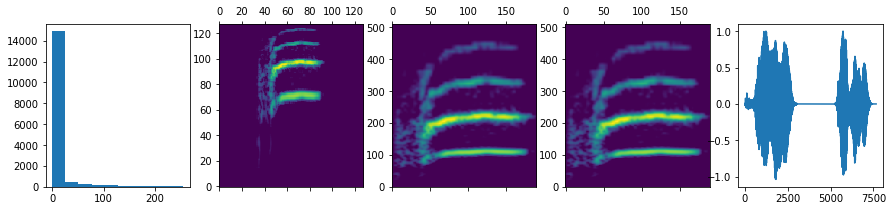

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=5, figsize=(15,3))
_ = ax[0].hist(syll.flatten())
ax[1].matshow(zero_one_norm(syll.astype('float32')), origin='lower', aspect='auto')
ax[2].matshow(zero_one_norm(syll_resized.astype('float32')), origin='lower', aspect='auto')
ax[3].matshow(zero_one_norm(syll_scaled.astype('float32')), origin='lower', aspect='auto')
ax[4].plot(joined_wavs)
plt.show()
IPython.display.Audio(
    data=joined_wavs,
    rate=rate,
)